# Parameter Selection for NMF

Now we look at the more advanced task of parameter selection for NMF topic modelling - namely, selecting a useful value for the number of topics *k*.

First, let's load the TF-IDF normalised document-term matrix and list of terms that we stored earlier using *Joblib*:

In [1]:
import joblib

(A, terms, snippets) = joblib.load("21cenario1-tweets-tfidf.pkl")

print("Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]))

Loaded 2452640 X 29011 document-term matrix


### Create the Topic Models

A common approach for parameter selection is to Measure and compare the topic coherence of models generated for different values of *k*.

We need to start by pre-specifying an initial range of "sensible" values:

In [2]:
kmin, kmax = 5, 20

Apply NMF for each of these values:

In [3]:
from sklearn import decomposition

topic_models = []

# try each value of k
for k in [5,10,15,20]: #range(kmin, kmax + 1):
    print("Applying NMF for k=%d ..." % k)
    # run NMF
    model = decomposition.NMF(init="nndsvd", n_components=k)
    W = model.fit_transform(A)
    H = model.components_
    # store for later
    topic_models.append((k, W, H))

Applying NMF for k=5 ...
Applying NMF for k=10 ...
Applying NMF for k=15 ...
Applying NMF for k=20 ...


### Build a Word Embedding

To select the number of topics, here we will use a *topic coherence* measure called TC-W2V. This measure relies on the use of a *word embedding* model constructed from our corpus. So in this step we will use the *Gensim* implementation of Word2Vec to build a Word2Vec model based on our collection of news articles.

**Note:** If you want to skip this step, a pre-built Word2Vec model for the sample dataset [is also provided here for download](http://erdos.ucd.ie/files/pydata/w2v-model.bin) (71MB).

We read the documents from the input file again:

In [4]:
import os.path

raw_documents = []

with open(os.path.join("cenario1_8M2021_tweets_en.txt"), "r") as fin:
    for line in fin.readlines():
        raw_documents.append(line.strip().lower())

print("Read %d raw text documents" % len(raw_documents))

Read 2452640 raw text documents


Read the custom stopword list:

In [5]:
custom_stop_words = []

with open("english.txt", "r") as fin:
    for line in fin.readlines():
        custom_stop_words.append(line.strip().lower())

# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words))

Stopword list has 179 entries


First, we need to define a class that will generate documents in a form that can be consumed by Gensim's Word2Vec implementation:

In [6]:
import re


class TokenGenerator:
    def __init__(self, documents, stopwords):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile(r"(?u)\b\w\w+\b")

    def __iter__(self):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall(doc):
                if tok in self.stopwords:
                    tokens.append("<stopword>")
                elif len(tok) >= 2:
                    tokens.append(tok)
            yield tokens

Now build a Skipgram Word2Vec model from all documents in the input file using *Gensim*:

In [7]:
import gensim

In [8]:
docgen = TokenGenerator(raw_documents, custom_stop_words)

# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [9]:
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 29431 terms


Save for later use, so that we do not need to rebuild it:

In [10]:
w2v_model.save("21cenario1_w2v-model.bin")

In [11]:
# To re-load this model, run
# w2v_model = gensim.models.Word2Vec.load("cenario1_w2v-model.bin")

### Selecting the Number of Topics

Once we have our Word2vec model, we can use it as part of our *topic coherence* approach to evaluate the different NMF topic models that we created previously. To do this, we will implement a simple version of the TC-W2V coherence measure.

We use the Word2vec model to calculate coherence scores for each of these models. We will define this coherence score as follows:

In [12]:
def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations(term_rankings[topic_index], 2):
            pair_scores.append(w2v_model.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

We also define a function to get the topic descriptor (i.e. list of top terms) for each topic:

In [13]:
import numpy as np


def get_descriptor(all_terms, H, topic_index, top):
    # reverse sort the values to sort the indices
    top_indices = np.argsort(H[topic_index, :])[::-1]
    
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    
    for term_index in top_indices[0:top]:
        top_terms.append(all_terms[term_index])
    
    return top_terms

Now process each of the models for different values of *k*:

In [14]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 10))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

K=05: Coherence=0.1961
K=10: Coherence=0.1819
K=15: Coherence=0.1781
K=20: Coherence=0.1852


/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


We can now use *matplotlib* to generate a line plot of these coherence scores, to help us select an appropriate value.

In [15]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

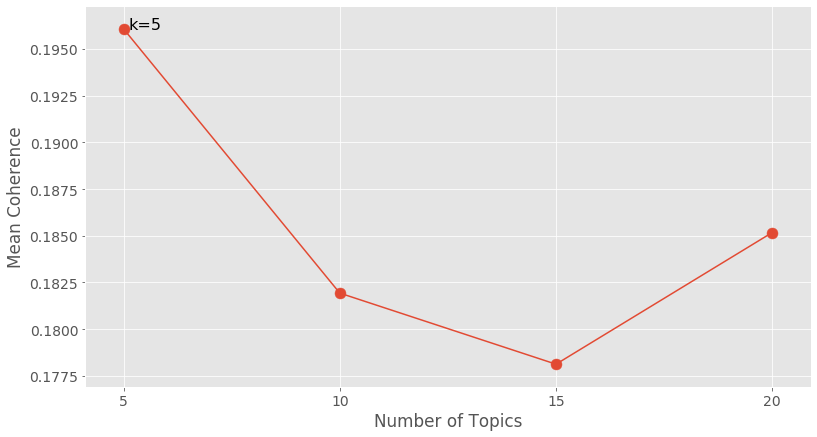

In [16]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

### Examine the Final  Model

The plot above suggests that the most appropriate value for the number of topics is *k=8*.

# 5

In [17]:
k = 5 # best_k

# get the model that we generated earlier.
W = topic_models[0][1]
H = topic_models[0][2]

Display the topic descriptors for this model:

In [18]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, beautiful, westview, ladies, day
Topic 02: day, international, women, march, men
Topic 03: pleasant, whatever, reason, trans, able
Topic 04: women, world, celebrate, today, amp
Topic 05: woman, god, every, love, mother


In [19]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, beautiful, westview, ladies, day, strong, powerful, wishing, queens, character
Topic 02: day, international, women, march, men, trans, great, womens, reminder, stepping
Topic 03: pleasant, whatever, reason, trans, able, wish, come, girls, international, reminder
Topic 04: women, world, celebrate, today, amp, amazing, thank, around, let, every
Topic 05: woman, god, every, love, mother, abundance, strength, thank, day, today


In [20]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, beautiful, westview, ladies, day, strong, powerful, wishing, queens, character, bitches, fiction, everyone, looked, iwd
Topic 02: day, international, women, march, men, trans, great, womens, reminder, stepping, every, help, like, congratulations, feel
Topic 03: pleasant, whatever, reason, trans, able, wish, come, girls, international, reminder, women, help, black, free, petitions
Topic 04: women, world, celebrate, today, amp, amazing, thank, around, let, every, celebrating, strong, honor, girls, gender
Topic 05: woman, god, every, love, mother, abundance, strength, thank, day, today, wonderful, ever, earth, teachings, life


In [21]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, beautiful, westview, ladies, day, strong, powerful, wishing, queens, character, bitches, fiction, everyone, looked, iwd, women, incredible, bad, female, love
Topic 02: day, international, women, march, men, trans, great, womens, reminder, stepping, every, help, like, congratulations, feel, petitions, tweets, ladies, one, celebrating
Topic 03: pleasant, whatever, reason, trans, able, wish, come, girls, international, reminder, women, help, black, free, petitions, tweets, feel, leave, especially, simple
Topic 04: women, world, celebrate, today, amp, amazing, thank, around, let, every, celebrating, strong, honor, girls, gender, support, playlist, stream, curated, work
Topic 05: woman, god, every, love, mother, abundance, strength, thank, day, today, wonderful, ever, earth, teachings, life, influential, growing, guidance, care, strong


# 10

In [22]:
k = 10 # best_k

# get the model that we generated earlier.
W = topic_models[1][1]
H = topic_models[1][2]

In [23]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, day, beautiful, ladies, westview
Topic 02: international, day, women, march, men
Topic 03: pleasant, whatever, reason, trans, able
Topic 04: women, celebrating, support, world, work
Topic 05: woman, god, abundance, mother, wonderful
Topic 06: amazing, womens, playlist, curated, stream
Topic 07: thank, around, world, continued, keeping
Topic 08: every, today, day, strength, celebrate
Topic 09: amp, gender, equality, let, challenge
Topic 10: love, may, strong, know, much


In [24]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, day, beautiful, ladies, westview, powerful, women, bitches, wishing, bad
Topic 02: international, day, women, march, men, stepping, like, great, congratulations, ladies
Topic 03: pleasant, whatever, reason, trans, able, wish, come, girls, international, reminder
Topic 04: women, celebrating, support, world, work, trans, strong, westview, respect, life
Topic 05: woman, god, abundance, mother, wonderful, ever, teachings, earth, thank, influential
Topic 06: amazing, womens, playlist, curated, stream, world, honor, celebrate, around, bitches
Topic 07: thank, around, world, continued, keeping, healthy, supports, vital, tirelessly, worked
Topic 08: every, today, day, strength, celebrate, everyday, inspire, life, screen, continually
Topic 09: amp, gender, equality, let, challenge, beautiful, female, powerful, future, join
Topic 10: love, may, strong, know, much, beautiful, raise, ladies, queens, queen


In [25]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, day, beautiful, ladies, westview, powerful, women, bitches, wishing, bad, everyone, character, female, fiction, looked
Topic 02: international, day, women, march, men, stepping, like, great, congratulations, ladies, help, badge, feel, earned, petitions
Topic 03: pleasant, whatever, reason, trans, able, wish, come, girls, international, reminder, women, help, black, petitions, free
Topic 04: women, celebrating, support, world, work, trans, strong, westview, respect, life, incredible, many, rights, across, show
Topic 05: woman, god, abundance, mother, wonderful, ever, teachings, earth, thank, influential, growing, stands, guidance, care, courage
Topic 06: amazing, womens, playlist, curated, stream, world, honor, celebrate, around, bitches, bad, achievements, ros, challenge, today
Topic 07: thank, around, world, continued, keeping, healthy, supports, vital, tirelessly, worked, services, special, ensure, safe, covid
Topic 08: every, today, day, strength, celebrate, everyda

In [26]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, day, beautiful, ladies, westview, powerful, women, bitches, wishing, bad, everyone, character, female, fiction, looked, iwd, queens, amazing, woman, incredible
Topic 02: international, day, women, march, men, stepping, like, great, congratulations, ladies, help, badge, feel, earned, petitions, one, tweets, name, wonderful, pretty
Topic 03: pleasant, whatever, reason, trans, able, wish, come, girls, international, reminder, women, help, black, petitions, free, feel, tweets, leave, thinking, simple
Topic 04: women, celebrating, support, world, work, trans, strong, westview, respect, life, incredible, many, rights, across, show, history, power, today, celebrate, empowerment
Topic 05: woman, god, abundance, mother, wonderful, ever, teachings, earth, thank, influential, growing, stands, guidance, care, courage, name, life, strength, wonder, man
Topic 06: amazing, womens, playlist, curated, stream, world, honor, celebrate, around, bitches, bad, achievements, ros, challenge, 

# 15

In [27]:
k = 15 # best_k

# get the model that we generated earlier.
W = topic_models[2][1]
H = topic_models[2][2]

In [28]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, day, beautiful, ladies, women
Topic 02: international, day, women, march, men
Topic 03: pleasant, whatever, reason, trans, able
Topic 04: women, support, trans, work, respect
Topic 05: woman, god, abundance, mother, wonderful
Topic 06: amazing, womens, playlist, curated, stream
Topic 07: thank, continued, keeping, healthy, supports
Topic 08: every, today, day, strength, celebrate
Topic 09: amp, beautiful, powerful, gender, follow
Topic 10: may, strong, know, raise, beautiful
Topic 11: world, around, bitches, bad, gender
Topic 12: love, much, queens, ladies, respect
Topic 13: celebrating, westview, women, today, achievements
Topic 14: let, future, history, stop, formidable
Topic 15: female, first, character, fiction, looked


In [29]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, day, beautiful, ladies, women, powerful, wishing, everyone, iwd, queens
Topic 02: international, day, women, march, men, stepping, congratulations, like, great, ladies
Topic 03: pleasant, whatever, reason, trans, able, wish, come, girls, international, reminder
Topic 04: women, support, trans, work, respect, life, many, incredible, celebrate, amazing
Topic 05: woman, god, abundance, mother, wonderful, stands, ever, teachings, earth, influential
Topic 06: amazing, womens, playlist, curated, stream, celebrate, honor, world, today, ros
Topic 07: thank, continued, keeping, healthy, supports, vital, tirelessly, worked, services, special
Topic 08: every, today, day, strength, celebrate, everyday, inspire, screen, continually, life
Topic 09: amp, beautiful, powerful, gender, follow, wonder, chance, win, equality, convention
Topic 10: may, strong, know, raise, beautiful, women, powerful, ladies, place, unknown
Topic 11: world, around, bitches, bad, gender, challenge, equality,

In [30]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, day, beautiful, ladies, women, powerful, wishing, everyone, iwd, queens, amazing, westview, woman, incredible, gals
Topic 02: international, day, women, march, men, stepping, congratulations, like, great, ladies, badge, earned, one, feel, help
Topic 03: pleasant, whatever, reason, trans, able, wish, come, girls, international, reminder, women, help, black, petitions, free
Topic 04: women, support, trans, work, respect, life, many, incredible, celebrate, amazing, show, rights, across, men, empowerment
Topic 05: woman, god, abundance, mother, wonderful, stands, ever, teachings, earth, influential, growing, guidance, care, courage, name
Topic 06: amazing, womens, playlist, curated, stream, celebrate, honor, world, today, ros, work, achievements, songs, music, nengi
Topic 07: thank, continued, keeping, healthy, supports, vital, tirelessly, worked, services, special, safe, young, ensure, covid, let
Topic 08: every, today, day, strength, celebrate, everyday, inspire, screen,

In [31]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, day, beautiful, ladies, women, powerful, wishing, everyone, iwd, queens, amazing, westview, woman, incredible, gals, babes, birthday, strong, inspire, queen
Topic 02: international, day, women, march, men, stepping, congratulations, like, great, ladies, badge, earned, one, feel, help, name, hope, petitions, tweets, wonderful
Topic 03: pleasant, whatever, reason, trans, able, wish, come, girls, international, reminder, women, help, black, petitions, free, feel, tweets, leave, simple, thinking
Topic 04: women, support, trans, work, respect, life, many, incredible, celebrate, amazing, show, rights, across, men, empowerment, power, great, reminder, stand, pay
Topic 05: woman, god, abundance, mother, wonderful, stands, ever, teachings, earth, influential, growing, guidance, care, courage, name, life, thank, strength, wonder, man
Topic 06: amazing, womens, playlist, curated, stream, celebrate, honor, world, today, ros, work, achievements, songs, music, nengi, want, proud, la

# 20

In [32]:
k = 20 # best_k

# get the model that we generated earlier.
W = topic_models[3][1]
H = topic_models[3][2]

In [33]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, day, ladies, beautiful, everyone
Topic 02: international, day, women, march, men
Topic 03: pleasant, whatever, reason, able, wish
Topic 04: women, amazing, respect, day, life
Topic 05: woman, god, abundance, mother, wonderful
Topic 06: amazing, womens, playlist, curated, stream
Topic 07: thank, continued, keeping, supports, healthy
Topic 08: every, day, strength, inspire, screen
Topic 09: amp, beautiful, powerful, gender, follow
Topic 10: may, strong, know, raise, beautiful
Topic 11: world, around, bitches, bad, gender
Topic 12: love, much, ladies, queens, respect
Topic 13: celebrating, westview, women, achievements, join
Topic 14: let, future, history, stop, formidable
Topic 15: today, celebrate, everyday, join, achievements
Topic 16: female, first, character, fiction, looked
Topic 17: work, many, across, empowerment, india
Topic 18: support, show, sant, shri, bapu
Topic 19: help, great, black, feel, free
Topic 20: going, started, thread, mexico, murder


In [34]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, day, ladies, beautiful, everyone, wishing, iwd, queens, westview, powerful
Topic 02: international, day, women, march, men, stepping, congratulations, like, ladies, badge
Topic 03: pleasant, whatever, reason, able, wish, trans, come, girls, women, international
Topic 04: women, amazing, respect, day, life, trans, rights, incredible, men, power
Topic 05: woman, god, abundance, mother, wonderful, ever, teachings, earth, stands, influential
Topic 06: amazing, womens, playlist, curated, stream, honor, celebrate, world, work, ros
Topic 07: thank, continued, keeping, supports, healthy, vital, tirelessly, worked, services, special
Topic 08: every, day, strength, inspire, screen, continually, single, life, queen, today
Topic 09: amp, beautiful, powerful, gender, follow, wonder, chance, win, convention, pop
Topic 10: may, strong, know, raise, beautiful, women, powerful, ladies, place, unknown
Topic 11: world, around, bitches, bad, gender, equality, challenge, better, equal, gir

In [35]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, day, ladies, beautiful, everyone, wishing, iwd, queens, westview, powerful, woman, incredible, gals, babes, amazing
Topic 02: international, day, women, march, men, stepping, congratulations, like, ladies, badge, earned, name, hope, one, follow
Topic 03: pleasant, whatever, reason, able, wish, trans, come, girls, women, international, reminder, together, thinking, simple, wakes
Topic 04: women, amazing, respect, day, life, trans, rights, incredible, men, power, reminder, strong, pay, tweet, stand
Topic 05: woman, god, abundance, mother, wonderful, ever, teachings, earth, stands, influential, growing, guidance, care, courage, life
Topic 06: amazing, womens, playlist, curated, stream, honor, celebrate, world, work, ros, songs, want, music, ladies, listen
Topic 07: thank, continued, keeping, supports, healthy, vital, tirelessly, worked, services, special, safe, covid, ensure, young, let
Topic 08: every, day, strength, inspire, screen, continually, single, life, queen, tod

In [36]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, day, ladies, beautiful, everyone, wishing, iwd, queens, westview, powerful, woman, incredible, gals, babes, amazing, everyday, birthday, good, fantasy, lovely
Topic 02: international, day, women, march, men, stepping, congratulations, like, ladies, badge, earned, name, hope, one, follow, via, 8th, celebration, tomorrow, womens
Topic 03: pleasant, whatever, reason, able, wish, trans, come, girls, women, international, reminder, together, thinking, simple, wakes, especially, non, persist, binary, lot
Topic 04: women, amazing, respect, day, life, trans, rights, incredible, men, power, reminder, strong, pay, tweet, stand, beautiful, inspire, society, wonderful, brave
Topic 05: woman, god, abundance, mother, wonderful, ever, teachings, earth, stands, influential, growing, guidance, care, courage, life, name, strength, thank, wonder, man
Topic 06: amazing, womens, playlist, curated, stream, honor, celebrate, world, work, ros, songs, want, music, ladies, listen, many, proud, 